# AI DEMO - Summit -Tensorflow Dance Move Training

This note book should be able to run on the OCP4 Demo Cluster by simply selecting "Cell" and then "Run All" at the top of the page.

Running this notebook will:
* Pull gesture data from S3
* Preprocess the gesture data
* Train a Tensorflow neural network model
* Save the model for serving

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import time
import os

import itertools
import joblib

import s3fs

import numpy as np
import pandas as pd
import scipy
import scipy.stats

import matplotlib as mpl
import matplotlib.pylab as plt

from pathlib import Path
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras

---

In [3]:
motion_cols = [
    'acceleration_x', 'acceleration_y', 'acceleration_z',
    'rotation_alpha', 'rotation_beta', 'rotation_gamma',
]
orientation_cols = ['alpha', 'beta', 'gamma']

In [4]:
def process_cross_data(data, *, bins: dict = None, method: str = None):
    """Process collection of raw examples.
    
    :returns: bins, DataFrame
    """
    bins = bins or {}
    gesture = 'draw-cross'
    
    data_processed = []
    for ts, d in data.items(): #loop over each sample
        df = pd.DataFrame([], columns = motion_cols + ['timestamp'] + orientation_cols)
        
        acc_data = pd.DataFrame([x['acceleration'] for elem in d for x in elem['motion']])
        rot_data = pd.DataFrame([x['rotationRate'] for elem in d for x in elem['motion']])

        df[motion_cols] = pd.concat([acc_data, rot_data], axis=1)
        df['timestamp'] = pd.DataFrame(
            [x['timestamp'] for elem in d for x in elem['motion']])

        df = df \
            .sort_values('timestamp', ascending=True) \
            .drop('timestamp', axis=1)
        
        data_processed.append(df)
    
    data_clean = list(clean_data(data_processed))

    col_bins, feature_df = featurize(
        data_clean, label=gesture, col_bins=bins.get(gesture, None), method=method)
    
    return {gesture: col_bins}, feature_df

In [5]:
def process_motion_rotation(example: dict):
    """Process single raw example and returns dataframe.
    
    :returns: DataFrame
    """
    motion = np.array(example['motion'])
    orientation = np.array(example['orientation'])

    # process motion data
    df = pd.DataFrame([], columns = motion_cols + ['timestamp'] + orientation_cols)
    
    if len(motion) > 0:
        if motion.shape[1] == 7: # incl. acc and rotational velocities
            df[motion_cols + ['timestamp']] = pd.DataFrame(motion)
            
    # process orientation data
    if len(orientation) > 0:
        df[orientation_cols] = pd.DataFrame(orientation[:, :-1])

    df = df \
        .sort_values('timestamp', ascending=True) \
        .drop('timestamp', axis=1)
        
    return df

In [6]:
def process_dance_data(data, *,
                       bins: dict = None,
                       method: str = None):
    """Process raw data into single dataframe.
    
    :returns: bins, DataFrame
    """ 
    df = pd.DataFrame()
    bins = bins or {}
    
    for gesture, d in data.items(): # loop over each dance type
        data_clean = list(clean_data(
            process_motion_rotation(example) for example in d))
        
        col_bins, feature_df = featurize(
            data_clean, label=gesture, col_bins=bins.get(gesture, None), method=method)
        
        bins[gesture] = col_bins
        
        df = pd.concat([df, feature_df], axis=0, ignore_index=True)
        
    return bins, df

In [7]:
def clean_data(data: list) -> list:
    """Clean collection of dataframes."""
    def condition(df): return all(df[motion_cols].any()) and len(df) > 50
    
    return filter(condition, map(lambda df: df[motion_cols].dropna(), data))

In [8]:
def featurize(data, *, label: str = None, col_bins: dict = None, method: str = None):
    """Featurize."""
    col_bins = col_bins or {}

    df = pd.DataFrame()
    for idx, col in enumerate(motion_cols):
        bins = col_bins.get(col, None)

        if bins is None:
            _, bins = find_bins(
                np.concatenate([d[col] for d in data]), method=method)
            col_bins[col] = bins

        TAG = col.upper()

        feature_list = []
        for d in data:
            ts = d[col]

            mean = np.mean(ts)
            median = np.median(ts)
            std = np.std(ts)
            length = len(ts)
            kurtosis = scipy.stats.kurtosis(ts)

            n,b = np.histogram(ts, bins=bins)
            n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin

            if median == 0: 
                features = {f'{TAG}_mean_over_median': 0, #dimensionless            
                            f'{TAG}_std_over_median': 0, #dimensionless            
                            f'{TAG}_length': length,
                            f'{TAG}_kurtosis': kurtosis, #already dimensionless by definition
                           }

            else: 
                features = {f'{TAG}_mean_over_median': mean/median, #dimensionless            
                    f'{TAG}_std_over_median': std/median, #dimensionless            
                    f'{TAG}_length': length,
                    f'{TAG}_kurtosis': kurtosis, #already dimensionless by definition
                   }

            for i, val in enumerate(n):
                features[f'{TAG}_binfrac_{i}'] = val
                
            feature_list.append(features)

        df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
            
    if label:
        df['label'] = label
        
    return col_bins, df.to_sparse()

In [9]:
def find_bins(x, method: str = None):
    """Find bin edges for histograms based on different methods."""
    if np.isscalar(x):
        x = [x]

    bins = method or mpl.rcParams['hist.bins']

    # basic input validation
    input_empty = np.size(x) == 0
    
    if input_empty:
        x = [np.array([])]
    else:
        x = mpl.cbook._reshape_2D(x, 'x')

    nx = len(x)  # number of datasets
    w  = [None] * nx

    xmin = np.inf
    xmax = -np.inf
    for xi in x:
        if len(xi) > 0:
            xmin = min(xmin, np.nanmin(xi))
            xmax = max(xmax, np.nanmax(xi))
    bin_range = (xmin, xmax)

    # List to store all the top coordinates of the histograms
    tops = []
    mlast = None

    hist_kwargs = dict(range=bin_range)

    # Loop through datasets
    for i in range(nx):
        # this will automatically overwrite bins,
        # so that each histogram uses the same bins
        m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)
        m = m.astype(float)  # causes problems later if it's an int
        tops.append(m)

    return tops, bins

In [10]:
def find_col_bins(data, method: str = None, export: str = None):
    """Find bins for every column in the data. Optinally exports as JSON."""
    data = list(data)

    df = pd.DataFrame()
    col_bins = {}
    
    for idx, col in enumerate(motion_cols):
        bins = col_bins.get(col, None)

        if bins is None:
            _, bins = find_bins(
                np.concatenate([d[col] for d in data]), method=method)
            col_bins[col] = bins
            
    if export:
        bins_export = Path(export)
        bins_export.parent.mkdir(parents=True, exist_ok=True)

        bins_export.write_text(json.dumps({
            col: bins.tolist() for col, bins in col_bins.items()
        }))
    
    return col_bins

---

### Data Loading

In [11]:
def get_raw_data(fs, path, debug=False):
    '''Reads raw data from S3 - not parallelized
    '''
    data = {}
    
    gestures_paths = fs.ls(path)
    
    for gesture in gestures_paths:
        files_to_read = fs.ls(gesture)
    
        key = gesture.split('/')[-1] 
        data[key] = []
        if debug:
            print(key)
    
        for file in files_to_read:
            with fs.open(file) as f:
                content = json.loads(f.read())
            data[key].append(content)
    
    return data

In [12]:
fs = s3fs.S3FileSystem()

In [13]:
path_to_dance_data = 'cchase-rh-demo-4/training-data'
path_to_cross_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-26'

In [ ]:
data_dance_raw = get_raw_data(fs, path_to_dance_data, debug=False)
data_cross_raw = get_raw_data(fs, path_to_cross_data, debug=False)

or

In [15]:
data_dance_raw = json.loads(Path('data/dance/data_dance_raw.json').read_text())
data_cross_raw = json.loads(Path('data/dance/data_cross_raw.json').read_text())

In [16]:
# For training

bins_dance, dance_data = process_dance_data(data_dance_raw)
bins_cross, cross_data = process_cross_data(data_cross_raw)

bins = {**bins_dance, **bins_cross}

df = pd.concat([dance_data, cross_data], axis=0, ignore_index=True)

In [17]:
df = df[~df['label'].isin(['draw-triangle'])]

df['label'].value_counts()

draw-cross     185
roll           137
shake          136
fever          123
draw-circle    121
floss          110
Name: label, dtype: int64

In [18]:
np.random.seed(42)

train_df, test_df = train_test_split(df, stratify=df['label'], test_size=0.20)

In [19]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [20]:
model = keras.Sequential([
    keras.layers.Dense(30, activation=tf.nn.sigmoid, input_shape=(84,)),
    keras.layers.Dropout(0.05, seed=42),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

optimizer = keras.optimizers.Adam(lr=1e-3)
loss      = tf.nn.softmax_cross_entropy_with_logits_v2
metrics   = ['accuracy']

model.compile(optimizer=optimizer,  loss=loss, metrics=metrics)

history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=15, steps_per_epoch=200, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/15
200/200 [==============================] - 5s 27ms/step - loss: 1.7257 - acc: 0.3063
Epoch 2/15
200/200 [==============================] - 5s 25ms/step - loss: 1.3967 - acc: 0.4875
Epoch 3/15
200/200 [==============================] - 5s 24ms/step - loss: 1.0740 - acc: 0.6574: 1s - loss: 1
Epoch 4/15
200/200 [==============================] - 5s 25ms/step - loss: 0.7633 - acc: 0.7989
Epoch 5/15
200/200 [==============================] - 5s 24ms/step - loss: 0.5589 - acc: 0.8779
Epoch 6/15
200/200 [==============================] - 5s 25ms/step - loss: 0.4258 - acc: 0.9154
Epoch 7/15
200/200 [==============================] - 6s 29ms/step - loss: 0.3304 - acc: 0.9343
Epoch 8/15
200/200 [==============================] - 5s 25ms/step - loss: 0.2483 - acc: 0.9508
Epoch 9/15
200/200 [===========

In [21]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1).values, test_onehot)

print('Test accuracy:', test_acc)

163/163 [==============================] - 0s 816us/sample - loss: 0.1802 - acc: 0.9387
Test accuracy: 0.9386503


Text(0, 0.5, 'predicted')

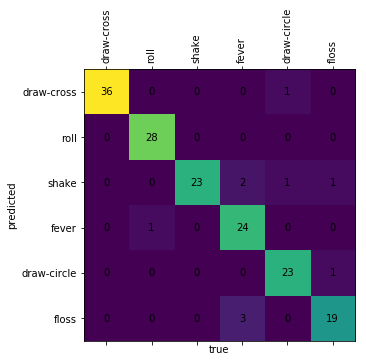

In [22]:
y_hat = model.predict(test_df.drop('label', axis=1).values)
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [23]:
print(classification_report(test_label, y_hat, labels=labels))

              precision    recall  f1-score   support

  draw-cross       1.00      0.97      0.99        37
        roll       0.97      1.00      0.98        28
       shake       1.00      0.85      0.92        27
       fever       0.83      0.96      0.89        25
 draw-circle       0.92      0.96      0.94        24
       floss       0.90      0.86      0.88        22

   micro avg       0.94      0.94      0.94       163
   macro avg       0.94      0.93      0.93       163
weighted avg       0.94      0.94      0.94       163



In [ ]:
save = True
ver = int(dt.now().timestamp())

if save:
    # export column bins
    bins_export = Path('models/v5/bins.json')
    bins_export.parent.mkdir(parents=True, exist_ok=True)

    bins_export.write_text(json.dumps({
        gesture: {
            col: bins.tolist() for col, bins in col_bin.items()
        } for gesture, col_bin in bins.items()
    }))
    
    # export encoder
    joblib.dump(label_encoder, 'models/v5/encoder.joblib')
    
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"models/v5/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}

## Prediction

### Local

In [24]:
import requests

data = {
    "instances": data_dance_raw['floss'][-5:] + data_dance_raw['roll'][-5:]
}
json_response = requests.post("http://localhost:5000/model/predict", json=data, headers={"Host": 'localhost', "Content-Type":"application/json"})

print(json.dumps(json_response.json(), indent=4))

{
    "payload": [
        {
            "candidate": "floss",
            "candidate_score": 0.9237101078033447,
            "predictions": {
                "draw-circle": 0.0021675480529665947,
                "draw-cross": 0.008985825814306736,
                "fever": 0.051649272441864014,
                "floss": 0.9237101078033447,
                "roll": 0.01318399515002966,
                "shake": 0.0003031643573194742
            }
        },
        {
            "candidate": "floss",
            "candidate_score": 0.9088186025619507,
            "predictions": {
                "draw-circle": 0.0003327102167531848,
                "draw-cross": 0.06489600241184235,
                "fever": 0.023357123136520386,
                "floss": 0.9088186025619507,
                "roll": 0.0023433221504092216,
                "shake": 0.00025227564037777483
            }
        },
        {
            "candidate": "floss",
            "candidate_score": 0.9864218831062317,
      

### Knative

In [ ]:
%%bash

oc start-build tf-serving --from-dir .

In [ ]:
builds = !oc get builds
latest = builds[-1].split()[0]

!oc logs -f build.build.openshift.io/$latest

In [ ]:
revision = int(dt.timestamp(dt.now()))

!oc process tf-serving-knative -p REVISION=$revision | oc apply -f -

In [ ]:
%%bash

while oc get pods | grep tf-serving-knative | grep -v Running; do 
    oc get pods | grep tf-serving-knative
    sleep 1
done

In [ ]:
%%bash --out KSERVICE_DOMAIN

oc get kservice tf-serving-knative-demo -o jsonpath='{.status.domain}'

In [ ]:
KSERVICE_DOMAIN

In [ ]:
import requests

INGRESS_GATEWAY="istio-ingressgateway.istio-system.svc.cluster.local"

data = {
  "instances": [
      json.loads(Path('data/dance/floss/example.json').read_text())
  ]
}
json_response = requests.post("http://%s/model/predict" % INGRESS_GATEWAY, json=data, headers={"Host": KSERVICE_DOMAIN, "Content-Type":"application/json"})

print(json.dumps(json_response.json(), indent=4))